# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.

X, Y = fetch_openml('mnist_784', return_X_y=True , cache=False)
Y.astype(int)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

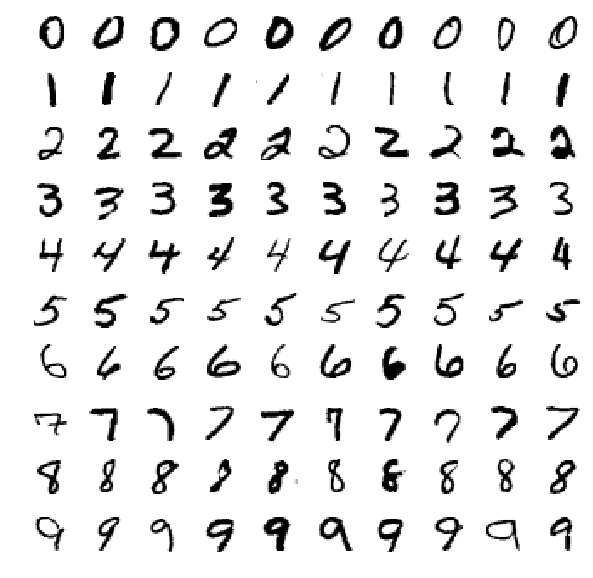

In [3]:
#def P1(num_examples=10):

### STUDENT START ###

def P1(num_examples=10):
    """Generates nxn grid with 10 examples of each digit
    
    Args:
        num_examples: number of examples per digit
    """
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(10):
        # Get only images with digit i
        X_i = X[np.isin(Y, str(i)), ]
        # Plot
        for j in range(10):
            sub = fig.add_subplot(10, 10, (10*i) + (j + 1))
            sub.imshow(np.reshape(a=X_i[j], newshape=(28, 28)), cmap=plt.cm.gray_r)
            sub.axis('off')

P1(10)

### STUDENT END ###

#P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
#def P2(k_values):

### STUDENT START ###

def P2(k_values):
    """Evaluate K-Nearest-Neighbors model and print performance metrics.
    
    Args:
        k_values: list with different K's, where K is the number of neighbors.
    """    
    for i in range(len(k_values)):
        
        # Train model with i-th value of k_values
        nn_clf = KNeighborsClassifier(n_neighbors=k_values[i])
        nn_clf = nn_clf.fit(mini_train_data, mini_train_labels)
        
        # Predict dev set values and print accuracy
        nn_predict = nn_clf.predict(dev_data)
        nn_accuracy = nn_clf.score(dev_data, dev_labels)
        k_value = k_values[i]
        print("Accuracy (K=", k_value, ") = ", nn_accuracy, sep = "")
        
        # If k=1, print precision, accuracy and F1
        if k_value == 1:
            print("")
            print("K=1")
            print(classification_report(dev_labels, nn_predict))

# Test P2 function
k_values = list(range(1, 10, 2))
P2(k_values)

### STUDENT END ###

#k_values = [1, 3, 5, 7, 9]
#P2(k_values)

Accuracy (K=1) = 0.884

K=1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

Accuracy (K=3) = 0.876
Accuracy (K=5) = 0.882
Accuracy (K=7) = 0.877
Accuracy (K=9) = 0.875


ANSWER: For $K=1$, the most difficult digit to recognize is the $8$, since it has the lower **recall** of all the digits (0.77). The reason to focus on recall, instead of precision or accuracy, is that the goal of correctly identifying each digit, measured as the percentage of true positives over the actual positives, seems to be a more relevant one in real life situations, i.e.,

$$\text{recall} = \frac{\text{true_positives}}{{\text{true_positives} + \text{false_negatives}}}$$

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
#def P3(train_sizes, accuracies):

### STUDENT START ###

def P3(train_sizes, accuracies):
    """ Calculate accuracy and prediction times for different
        sizes of training data
        
    Args:
        train_sizes: sequence of training set sizes
        accuracies: empty list    
    """
    print("N", "\t", "Time", "\t", "Accuracy", sep="")
    print("-" * 25)
    for size in train_sizes:
        
        # Fit model for given size
        data = train_data[:size, ]
        labels = train_labels[:size, ]
        nn_model = KNeighborsClassifier(n_neighbors=1).fit(data, labels)
        
        # Calculate accuracy and prediction time
        start = time.time()
        nn_model.predict(dev_data)
        end = time.time()
        accuracy = nn_model.score(dev_data, dev_labels)
        accuracies.append(accuracy)
        
        print(size, "\t", round(end - start, 2), "s \t", round(accuracy, 2),  sep = "")
        
    return accuracies

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

### STUDENT END ###

#train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
#accuracies = []
#P3(train_sizes, accuracies)

N	Time	Accuracy
-------------------------
100	0.13s 	0.7
200	0.25s 	0.79
400	0.6s 	0.81
800	1.07s 	0.87
1600	2.34s 	0.9
3200	4.74s 	0.93
6400	9.0s 	0.94
12800	16.46s 	0.95
25000	34.14s 	0.96


[0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.962]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Predicted accuracy (n=60,000): 1.24


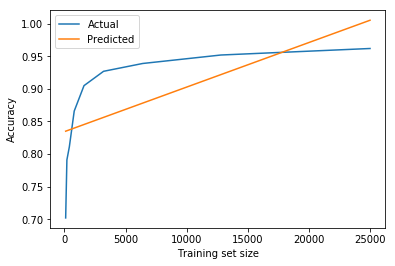

In [6]:
#def P4():

### STUDENT START ###

def P4(train_sizes, accuracies):
    """ Fits a linear regression that predicts accuracy from training size
    
    Args:
        train_sizes: training sizes sequence
        accuracies: accuracies sequence
    """
    # Train linear model
    train_sizes = np.array(train_sizes).reshape(-1, 1)
    accuracies = np.array(accuracies)
    lin_model = LinearRegression().fit(train_sizes, accuracies)

    # Predict
    predicted = lin_model.predict(np.array([60000]).reshape(-1, 1))
    print("Predicted accuracy (n=60,000):", round(predicted[0], 2))
    
    # Plot train sizes and accuracies
    plt.plot(train_sizes, accuracies, label="Actual")
    plt.plot(train_sizes, lin_model.predict(train_sizes), label="Predicted")
    plt.ylabel("Accuracy")
    plt.xlabel("Training set size")
    plt.legend()

P4(train_sizes, accuracies)

### STUDENT END ###

#P4()

Log-linear transformation

Predicted accuracy (n=60,000): 2662.8


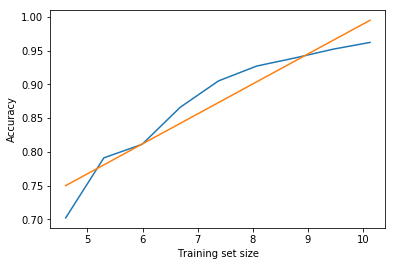

In [7]:
#def P4():

### STUDENT START ###

def P4_b(train_sizes, accuracies):
    """ Fits a linear regression that predicts accuracy from training size
    
    Args:
        train_sizes: training sizes sequence
        accuracies: accuracies sequence
    """
    # Train linear model
    train_sizes_log = np.log(np.array(train_sizes)).reshape(-1, 1)
    accuracies = np.array(accuracies)
    lin_model = LinearRegression().fit(train_sizes_log, accuracies)

    # Predict
    predicted = lin_model.predict(np.array([60000]).reshape(-1, 1))
    print("Predicted accuracy (n=60,000):", round(predicted[0], 2))
    
    # Plot train sizes and accuracies
    plt.plot(train_sizes_log, accuracies, label="Actual")
    plt.plot(train_sizes_log, lin_model.predict(train_sizes_log), label="Predicted")
    plt.ylabel("Accuracy")
    plt.xlabel("Training set size")

P4_b(train_sizes, accuracies)

### STUDENT END ###

#P4()

ANSWER: The predicted model's accuracy is outside of the accuracy function's codomain, i.e. $[0, 1]$. This can happen for two reasons. First, the model fitted with the untransformed variables assumes that the relationship between these is linear, with codomain on the real numbers; thus, it allows for values outside $[0, 1]$. Second, the model was trained for a small range of values, $[100, 25000]$, and the prediction is extrapolating, i.e. it is being done with an input that is different than the one it was trained with.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]

Confused cases per digit
0: 5
1: 2
2: 22
3: 13
4: 14
5: 11
6: 8
7: 6
8: 22
9: 13


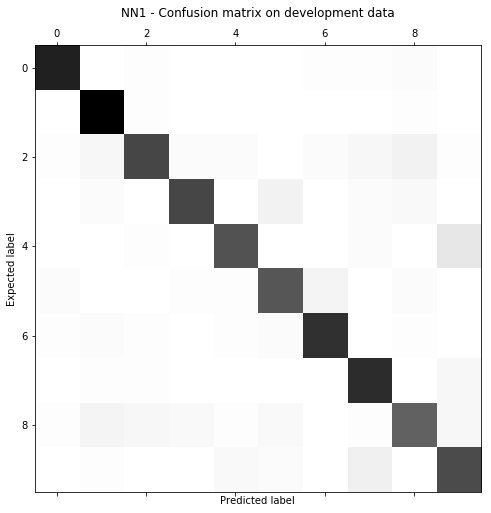

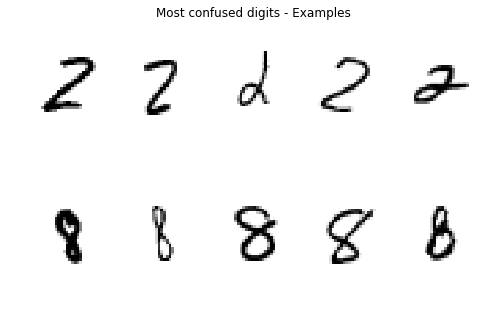

In [8]:
#def P5():

### STUDENT START ###

def P5():
    """Fits a Nearest Neighbours model with k=1 and prints confusion matrix
    """
    # Fit model and calculate confusion matrix
    nn1_model = KNeighborsClassifier(n_neighbors=1).fit(mini_train_data, mini_train_labels)
    nn1_predict = nn1_model.predict(dev_data)
    nn1_dev_conf = confusion_matrix(dev_labels, nn1_predict)
    
    # Print confusion matrix
    print("Confusion matrix")
    print("")
    print(nn1_dev_conf)
    matfig = plt.figure(figsize=(8, 8))
    plt.matshow(nn1_dev_conf, cmap=plt.cm.binary, interpolation='nearest', fignum=matfig.number)
    plt.title("NN1 - Confusion matrix on development data")
    plt.xlabel("Predicted label")
    plt.ylabel("Expected label")
    
    # Count confusions per digit
    digits_confusion = []
    print("")
    print("Confused cases per digit")
    for i in range(10):
        cases = 0
        for j in range(10):
            if i != j:
                cases += nn1_dev_conf[i, j]
        print(i, ": ", cases, sep = "")
        digits_confusion.append(cases)
        
    # Display 5 mistakes from top two most confused digits
    most_confused = [value for value in range(10) if digits_confusion[value] == max(digits_confusion)]
    mistakes_fig = plt.figure(figsize=(8, 5))
    plt.title("Most confused digits - Examples")
    plt.axis("off")
    for row in range(2):
        for col in range(5):
            mistakes = dev_data[(dev_labels != nn1_predict) & (dev_labels == str(most_confused[row]))]
            sub = mistakes_fig.add_subplot(2, 5, (5*row) + (col+1))
            sub.imshow(np.reshape(mistakes[col], (28, 28)), cmap=plt.cm.gray_r)
            sub.axis("off")
        
P5()

### STUDENT END ###

#P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [65]:
# Find adjacent elements
def find_adjacents(pixel, image):
    adjacent = []
    image_cols = image.shape[1] - 1
    for i in range(-1, 2):
        for j in range(-1, 2):
            new_row = pixel[0] + i
            new_col = pixel[1] + j
            if new_row < 0 or new_row > image_cols or new_col < 0 or new_col > image_cols:
                continue
            adjacent.append((new_row, new_col))
    return adjacent

# Find distance between two elements (Euclidean for the moment, but should  be Gaussian)
def inv_distance(e1, e2):
    # 1 / (((e1[0] - e2[0])**2 + (e1[1] - e2[1])**2) ** (1/2))
    return 1

# Blur a given pixel with adjacent pixels
def blur(pixel, image):
    adjacents = find_adjacents(pixel, image)
    pixel_w = 0
    distances = []   
    # Calculate distance b/n pixel and adjacents
    for adjacent in adjacents:
        distances.append(inv_distance(pixel, adjacent))
    # Calculate weight of each adjacent pixel
    sum_distances = np.sum(np.array(distances))
    for adjacent in adjacents:
        # Test case with equal weight
        # pixel_w += image[adjacent[0], adjacent[1]] * (inv_distance(pixel, adjacent) / sum_distances)
        pixel_w += image[adjacent[0], adjacent[1]] / sum_distances    
    return pixel_w

def blur_image(image):
    dim = 4
    image = np.reshape(image, (dim, dim))
    image_blurred = np.empty((dim, dim))
    for i in range(dim):
        for j in range(dim):
            image_blurred[i,j] = blur((i, j), image)
    return np.reshape(image_blurred, dim * dim)

def P6(data):
    data_blurred = np.empty((data.shape[0], data.shape[1]))
    for image_ind in range(data.shape[0]):
        

# # TEST blur_image
# image = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
# print(np.reshape(image, (4, 4)))
# blur_image(image)

# # TEST blur
# image = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])
# pixel = (3, 3)
# print(image)
# print(image[3, 3])
# find_adjacents(pixel, image)
# blur(pixel, image)

# # Take weighted average of each pixel (start with training data)
# def P6():
#     # Blur each pixel (repeat for training and development)
#     for row in 
#         # Reshape to 28x28
#         # np.pad(A, ((1,1),(1,1)), 'constant')
#         # Find adjacent pixels
#         # Take weighted average (including self)
#         # Flatten and add to data matrix
    
#     # Fit 
    
#     # Flatten and add to data matrix

# Remove pads

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([ 2.5,  3. ,  4. ,  4.5,  4.5,  5. ,  6. ,  6.5,  8.5,  9. , 10. ,
       10.5, 10.5, 11. , 12. , 12.5])

In [10]:
#def P6():
    
### STUDENT START ###


### STUDENT END ###

#P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
#def P7():

### STUDENT START ###


    
### STUDENT END ###

#P7()

ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [12]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

#alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#nb = P8(alphas)

In [14]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [15]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#gnb = P9()

ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [16]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()